In [ ]:
pip install kaggle --upgrade

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'ekgusqksksk'
os.environ['KAGGLE_KEY'] = 'aa1e6d5483fd4cfd99e17b389dbf695a'

In [ ]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

gender_submission.csv  sample_data  test.csv  train.csv


In [ ]:
pip install -U scikit-learn

## Introduction

이 노트는 기본 학습 모델, 특히 stacking으로 알려진 앙상블의 변형에 대해 앙상블하는 방법에 대한 매우 기본적이고 간단한 입문서다.

In [ ]:
# load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking (스태킹 시 사용할 5가지 기본모델)
from sklearn.ensemble import(RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
# from sklearn.cross_validation import KFold # 에러남, 아래 셀로 변경
from sklearn.model_selection import KFold # 재현님 땡큐

## Feature Exploration, Engineering and Cleaning

이제 우리는 대부분의 커널이 일반적으로 구조화되는 방식과 매우 비슷하게 진행할 것이다. 즉 현재 데이터 탐색한 후 가능한 피쳐 엔지니어링 기회를 식별하며 범주형 피쳐를 수치적으로 인코딩한다

- EDA 후 범주형 피쳐 -> 수치화 

In [ ]:
# Load in the train and test datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Store our passenger ID for easy access
PassengerID = test['PassengerId']
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Feature Engineering


In [ ]:
full_data = [train, test]

# Some features of my own that I have added in (내 맘대로 피쳐 추가)
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len) 
test['Name_length'] = test['Name'].apply(len)
                                # apply() = Pandas dataframe을 엑셀의 매크로 함수처럼 각 열에 대한 연산을 하는 방법, 기존 컬럼을 가지고 새로운 컬럼을 만든다

# Feature that tells whether a passenger had a cabin on the titanic (카빈 가진 승객)
train['Has_Cabin'] = train["Cabin"].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x : 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize (혼자)
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all Nulls in the Embarked column (항구 컬럼에서 널값 제거)
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S') # S로 채운다
# Remove all Nulls in the Fare column and create a new feature CategoricalFare (요금 컬럼의 널값 지우고 categoricalFare라는 새로운 컬럼 추가)
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New Feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names 승객 이름으로부터 타이틀 만드는 함수 정의
def get_title(name) :
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it. 제목이 있으면 반환
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single groupin "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':2}).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 

In [ ]:
# feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

이제 피쳐 정리해서 정보 추출하고 범주형 열을 삭제했다
- 모든 피쳐는 이제 수치형이다. (기계학습에 적합한 형식)
- 변환된 데이터 세트의 상관관계와 분포도를 생성해보자

## Visualisations

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


### Pearson Correlation Heatmap 피어슨 상관계수 히트맵

- seaborn plot package 활용

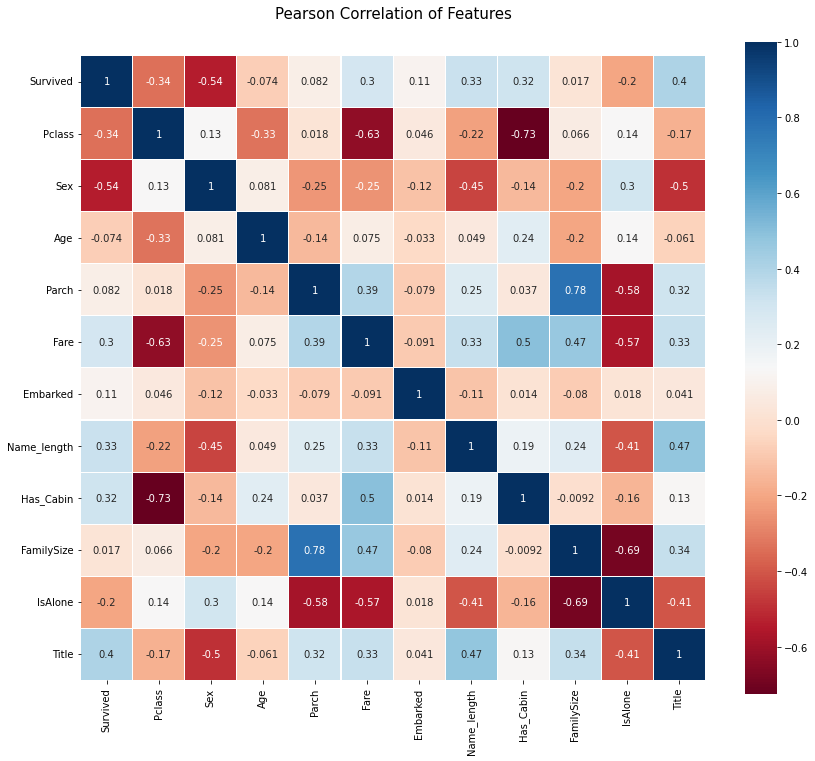

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

### Takeaway from the plots

- 피어슨 상관그림을 통해 서로 강하게 연관된 특징이 많지 않다는 것을 알 수 있다 -> good

### Pairplots 

- seaborn으로 pairplots을 만들어보자

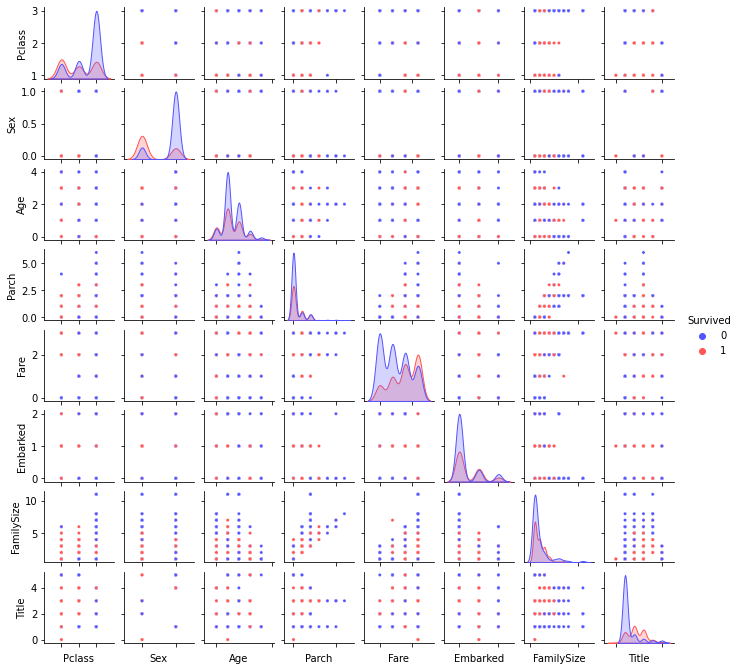

In [ ]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models

creating a Stacking ensemble

## Helpers via Python Classes

- 파이썬 클래스를 호출해서 사용
- 아래에서 모든 sklearn분류기에 공통되는 내장 메서드를 확장할수있는 클래스 sklearnHelper를 작성한다.
- 따라서 5개의 다른 분류기를 호출하고자 할 때 동일한 메소드를 쓸 필요가 없어서 중복성을 차단한다

In [ ]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)

# Class to extend XGboost classifer

def init : 클래스에 대한 기본 생성자를 호출하기 위한 파이썬 스탠다드...? 즉 객체를 만들려면 clf(원하는 sklearn분류기) 시드(랜덤 시드) 파라미터(매개 변수)를 제공해야 한다

코드의 나머지는 단순히 sklearn분류기에 이미 존재하는 해당 메소드를 호출하는 거... 우리는 다양한 skelearn분류기를 확장하기 위해 ... 여러 학습자를 스택커에 구현할 때 동일한 코드를 반복해서 작성해야 하는 것을 줄였다

### Out of fold predictions

스택은 두번째 수준 모델에 대한 훈련을 위한 입력으로 기본 분류자의 예측을 사용한다. 그러나 단순히 전체 훈련 데이터에 대한 기본 모델을 훈련하고 전체 테스트 세트에 대한 예측을 생성한 다음 2차 훈련을 위해 이를 출력할 수는 없다. 이렇게 하면 기본 모형 예측이 검정 집합을 이미 보여서 이러한 예측을 제공할 때 과적합될 위험이 있다..

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

첫번째 레벨 분류로 다섯가지 학습 모델을 준비한다. 

1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine


### Parameters
파라미터 요약

n_jobs : 훈련 프로세스에 사용되는 코어 수 , -1로 설정하면 모든 코어 사용

n_estimators : 학습 모델의 분류 트리 수(기본값 당 10으로 설정)

max_depth : 트리의 최대 깊이 또는 노드를 확장할 크기, 너무 높게 설정하면 너무 깊어져서 과적합의 위험이 있으므로 주의

verbose : 학습 프로세스 중에 텍스트를 출력할지 여부제어, 0이면 모든 텍스트 억제 3은 반복할때마다 트리 학습 프로세스 출력


In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

또한, OOP프레임워크 내의 개체와 클래스에 대해 언급했으므로 앞에서 정의한 Helper Sklearn Class를 통해 5가지 학습 모델을 나타내는 5가지 개체를 생성해보자

In [ ]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating Numpy arrays out of our train and test sets

이제 첫번째 레이어 기본 모델을 준비했으니 이제 numpy어레이를 원래 데이터 프레임에서 생성해서 분류기에 입력하기 위한 train, test데이터를 준비하자

In [ ]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

### Output of tje First level Predictions

이제 훈련 및 테스트 데이터를 5개의 기본 분류기에 넣고 앞에서 정의한 out-of-fold예측 함수를 사용해서 첫번째 수준 예측을 생성한다

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### feature importances generated from the different clssifiers

sklearn 설명서에 따르면 대부분의 분류자는 featureimports를 입력하기만 하면 기능 중요도를 반환하는 속성이 내장되어 있다. 따라서 우리는 함수 접지?를 통해 이 유용한 속성을 호출하고 피쳐의 중요성을 플롯할 것이다.. 

In [ ]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.1059622  0.22170567 0.0380115  0.01971972 0.04731059 0.02971306
 0.13116985 0.04911278 0.06926489 0.01184804 0.27618169]
[0.12115835 0.38502803 0.03279676 0.01694086 0.05613751 0.02821884
 0.04855281 0.08327305 0.04605199 0.02182936 0.16001242]
[0.034 0.01  0.018 0.066 0.038 0.008 0.694 0.014 0.046 0.002 0.07 ]
[0.08526693 0.01211501 0.05754616 0.01069685 0.04924579 0.02394951
 0.17994744 0.04303477 0.10927081 0.00580174 0.42312499]


기능적 중요도를 어떻게 할당하고 저장해야 할 지 아직 파악하지 못했다. 그러므로 위의 코드값을 출력한 후 아래와같이 파이썬 목록에 복사하여 붙여넣을 것 !!

In [ ]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

plotly 패키지를 통해 쉽게 플로팅할 수 있도록 피쳐 중요도 데이터가 포함된 리스트에서 데이터 프레임을 작성한담

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features':cols,
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees feature importances' : et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features
                                   })

### Interactive feature importances via Plotly scatterplots

- 반응형 plotly패키지를 사용해서 scatter를 호출해보자
- 여러 분류기의 피쳐 중요도 값 시각화

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

이제 모든 피쳐 중요도의 평균을 계산해서 중요도 데이터 프레임에 새 열로 저장하자

In [ ]:
# Create the new column contarining the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis = 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


### Plotly barplot of Average Feature Importances

모든 분류기의 피쳐 중요도의 평균을 얻었으니까 다음과 같이 플로틀리 막대 플롯으로 표시할 수 있다

In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x = x,
    y = y,
    width = 0.5,
    marker = dict(
        color = feature_dataframe['mean'].values,
    colorscale = 'Portland',
    showscale = True,
    reversescale = False
    ),
    opacity = 0.6
)]

layout = go.Layout(
    autosize = True,
    title = 'Barplots of Mean Feature Importance',
    hovermode = 'closest',
    # xaxis = dict(
    #     title = 'Pop',
    #     ticklen = 5,
    #     zeroline = False,
    #     gridwidth = 2,
    # ),
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

### Second-Level Predictions from the First-level output

#### First-level output as new features
첫번째 수준의 예측을 얻었으므로, 다음 분류기의 훈련 데이터로 사용될 새로운 피쳐세트를 구축하자.?? 아래 코드에 따라 새로운 컬럼으로 이전 분류기들의 첫번째 레벨 예측을 가지고 다음 분류기를 교육한다

In [ ]:
base_predictions_train = pd.DataFrame({'RandomForest' :  rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost' : ada_oof_train.ravel(),
                                       'GradientBoost' : gb_oof_train.ravel()
                                       })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


#### Correlation Heatmap of the Second level training set

In [ ]:
data = [
    go.Heatmap(
        z = base_predictions_train.astype(float).corr().values,
        x = base_predictions_train.columns.values,
        y = base_predictions_train.columns.values,
        colorscale = 'Viridis',
        showscale = True,
        reversescale = True
    )
]
# py.iplot(data, filename='labelled-heatmap') -> 수정
fig = go.Figure(data=data) 
fig.show(renderer="colab")

서로 상관관계가 없는 훈련된 모델들이 더 좋은 점수를 만들어 낼 수 있다는 기사들과 우승자들의 얘기가 꽤 있었다

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

이제 첫번째 수준의 훈련 및 테스트 예측을 연결 및 결합했으므로, 두번째 레벨 학습 모델을 적합 시킬 수 있다

### Second level learning model via XGBoost

여기서 우리는 boost tree 학습 모델인 xgboost로 매우 유명한 eXtreme라이브러리를 선택한다. 대규모 부스트 트리 알고리즘에 최적화되어 있음

어쨌든 우리는 xgb분류기를 호출해서 1차 훈련 및 타겟 데이터에 fit하고 학습된 모델을 사용해서 다음과 같이 테스트 데이터를 예측한다

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators = 2000,
    max_depth = 4, 
    min_child_weight = 2,
    #gamma = 1,
    gamma = 0.9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

max_depth = 위에서 했음

gamma = 트리의 리프 노드에서 추가 파티션을 만드는데 필요한 최소 손실 감소. 크기가 클수록 알고리즘을 더 보수적일 것이다

eta = 각 부스팅 단계에서 과적합을 방지하기 위해 단계 크기 축소를 사용한

#### producing the Submission file

마지막으로 모든 1단계 2단계 모델을 학습시키고 적합하게 조정한 후 다음과 같이 예측값을 제출하기 위한 형식으로 출력한다

In [ ]:
# Generate Submission File
StackingSubmission = pd.DataFrame({'PassengerId':PassengerID,
                                   'Survived':predictions})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

#### Steps for Further Improvement 

추가 개선을 위한 단계

위의 단계들은 앙상블 스태커를 만드는 아주 간단한 방법이었다.

점수를 높이기 위해 취할 수 있는 몇가지 추가 단계는 다음과 같음

최적의 모수 값을 찾기 위해 모델을 교육할 때 우수한 교차 검증 전략 구현, 학습을 위한 더 다양한 기본 모델을 사용, 상관관계가 없는 결과일수록 최종 점수가 더 좋다

# Conclusion

이 노트북이 학습 모델을 쌓는 작업 스크립트를 소개하는 데 어느 정도 도움이 되었다고 생각한다. .. 기타 우수한 자료는 MLWave: Kaggle Ensembling Guide의 사실적 필독 문서를 참조하라! 피스아웃!
